#  <font color='orange'>CUNEF</font>
# `Machine Learning`
# `Yelp Dataset`
# `03_Restaurants_Yelp`
## Authors:
### Jorge Plaza Yuste
### Álvaro Gómez Pérez

## Libraries

In [1]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Modeling and Metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

# Explicability
import shap 
from sklearn.inspection import PartialDependenceDisplay
import eli5
from eli5.sklearn import PermutationImportance

## Functions

#### Data loading and saving

In [2]:
def load_data(files):
    """
    Load the data from parque format.
    The output is a list of pandas dataframes.
    """    
    # Dataframe list:
    data = []
    
    # Iteration for loading each file:
    for i in range(0,len(files)): 

        # Store the dataframes
        reader = pd.read_parquet(files[i])

        data.append(reader)
        
    return data

def save_models_to_parquet(models, filenames):
    """
    Save the model to parquet.
    The file path must end with '.pkl'.
    """
    for model, file in zip(models, filenames):
        joblib.dump(model, file)

def load_models_from_parquet(files):
    """
    Load the models from parquet format.
    """    
    # Models list:
    models = []
    
    # Iteration for loading each model:
    for i in files: 

        # Loading and storing the models
        reader = joblib.load(i)
        models.append(reader)
        
    return models

#### Data Preprocessing

In [3]:
class encoder_pipeline():
    """
    One modification to the dataset
    -Encode the categorical data with the one hot encoder method
    
    """    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #Categrical features to pass down the categorical pipeline
        categorical_features = X.drop(X.columns[1:31],axis=1).columns
        transformer = make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'), categorical_features),
            remainder='passthrough')
        X = transformer.fit_transform(X)
        X = pd.DataFrame(X, columns=transformer.get_feature_names_out()).astype('int32')
        return X

#### Metrics

In [4]:
def confusion_matrix_plot(ytest, ypred):
    """
    Obtain the confusion matrix of the predictions for each model
    -Confusion matrix without normalization
    -Confusion matrix with normalization
    """
    cm = confusion_matrix(ytest, ypred)
    cm_norm = confusion_matrix(ytest, ypred, normalize='true')
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, 
                square = True, cmap = plt.cm.Blues,ax=ax1)
    ax1.set_title("Confusion matrix, without normalization")
    ax1.set_xlabel('Predicted values')
    ax1.set_ylabel('Real values')
    sns.heatmap(cm_norm, annot=True, fmt=".2f", linewidths=.5, 
                square = True, cmap = plt.cm.Blues,ax=ax2)
    ax2.set_title("Normalized confusion matrix")
    ax2.set_xlabel('Predicted values')
    ax2.set_ylabel('Real values')
    plt.tight_layout()
    
def show_metrics(y_true, y_pred, y_pred_proba, modelo):
    """
    Obtain the metrics for a specific model
    -accuracy
    -precision
    -recall
    -f2
    -auc
    """    
    accuracy = round(accuracy_score(y_true, y_pred),4)
    precision = round(precision_score(y_true, y_pred),4)
    recall = round(recall_score(y_true, y_pred),4)
    f0_5 = round(fbeta_score(y_true, y_pred, beta=0.5),4)
    auc = roc_auc_score(y_true, y_pred_proba[:,1])
    
    
    print(modelo, 'metrics: \n'\
         'Accuracy: ',str(accuracy),'\n'\
         'Precision: ',str(precision),'\n'\
         'Recall: ',str(recall),'\n'\
         'F0.5: ',str(f0_5),'\n'\
         'AUC: ',str(auc))
    
def plot_precision_recall_curve(ytest, prob_predictions, modelo):
    """
    -get precision - recall curve   
    """
    # keep probabilities for the positive outcome only
    yhat = prob_predictions[:, 1]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(ytest, yhat)
    # convert to f2 score
    f05_score = (1.25 * precision * recall) / (precision * 0.25 + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(f05_score)
    print('Best Threshold=%f, F0.5-Score=%.3f' % (thresholds[ix], f05_score[ix]))
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label=modelo)
    plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
def curves(ytest, prob_predictions):
    """
    -get the Roc Curve
    -get the cumulative_gain_curve
    -get the lift curve    
    """    
    f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)
    # ROC curve:
    # keep probabilities for the positive outcome only
    yhat = prob_predictions[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot the roc curve for the model
    ax1.plot([0,1], [0,1], linestyle='--', label='No Skill')
    ax1.plot(fpr, tpr, marker='.', label='Random Forest')
    ax1.set_title("ROC Curve")
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()
    
    # Gain curve:
    plot_cumulative_gain(ytest, prob_predictions, ax=ax2)
    
    # Lift Curve:
    plot_lift_curve(ytest, prob_predictions, ax=ax3)

## Data loading and display

In [5]:
# List of dataset path-files 
filenames = ["../data/restaurants_cleaned.parquet"]

# loading the datasets
restaurants_cleaned=(load_data(filenames))[0]

In [6]:
restaurants_cleaned.head()

name              address          city state postal_code  \
0     St Honore Pastries          935 Race St  Philadelphia    PA       19107   
1         Sonic Drive-In        615 S Main St  Ashland City    TN       37015   
2  Tsevi's Pub And Grill    8025 Mackenzie Rd        Affton    MO       63123   
3         Sonic Drive-In  2312 Dickerson Pike     Nashville    TN       37207   
4  Vietnamese Food Truck                          Tampa Bay    FL       33602   

    latitude  longitude stars  review_count is_open  ... Other Alcohol  \
0  39.955505 -75.155563   4.0            80       1  ...     1      No   
1  36.269592 -87.058945   2.0             6       1  ...     0      No   
2  38.565166 -90.321083   3.0            19       0  ...     0     Yes   
3  36.208103 -86.768173   1.5            10       1  ...     0      No   
4  27.955269 -82.456322   4.0            10       1  ...     0      No   

     HasTV RestaurantsReservations OutdoorSeating RestaurantsPriceRange2  \
0  Unknown                 Unknown             No                  Cheap   
1      Yes                      No            Yes                  Cheap   
2      Yes                      No            Yes                  Cheap   
3      Yes                      No            Yes                  Cheap   
4  Unknown                      No             No                Unknown   

  BusinessAcceptsCreditCards RestaurantsDelivery RestaurantsTakeOut  \
0                         No                  No                Yes   
1                        Yes                 Yes                Yes   
2                        Yes                  No                Yes   
3                        Yes                 Yes                Yes   
4                    Unknown             Unknown            Unknown   

  Premium_Parking  
0              No  
1              No  
2              No  
3         Unknown  
4         Unknown  

[5 rows x 48 columns]

### Variable Selection

We have decided to remove the location variables and keep only the `state` variable, since we consider that they provide similar information. At the same time, we removed the variable `is_open` because we consider that when we analyze the data in the future we will not have this variable. Therefore, we will value the observations without taking into account whether the business has closed or is still open.

In [7]:
drop_columns = ["address", "name","city","postal_code","latitude","longitude","is_open"]
restaurants = restaurants_cleaned.drop(columns=drop_columns)

In [8]:
restaurants.head()

state stars  review_count American Breakfast Traditional Sandwiches Burgers  \
0    PA   4.0            80        0         0           0          0       0   
1    TN   2.0             6        0         0           0          1       1   
2    MO   3.0            19        1         0           1          0       0   
3    TN   1.5            10        0         0           0          0       1   
4    FL   4.0            10        0         0           0          0       0   

  Mexican Italian  ... Other Alcohol    HasTV RestaurantsReservations  \
0       0       0  ...     1      No  Unknown                 Unknown   
1       0       0  ...     0      No      Yes                      No   
2       0       1  ...     0     Yes      Yes                      No   
3       0       0  ...     0      No      Yes                      No   
4       0       0  ...     0      No  Unknown                      No   

  OutdoorSeating RestaurantsPriceRange2 BusinessAcceptsCreditCards  \
0             No                  Cheap                         No   
1            Yes                  Cheap                        Yes   
2            Yes                  Cheap                        Yes   
3            Yes                  Cheap                        Yes   
4             No                Unknown                    Unknown   

  RestaurantsDelivery RestaurantsTakeOut Premium_Parking  
0                  No                Yes              No  
1                 Yes                Yes              No  
2                  No                Yes              No  
3                 Yes                Yes         Unknown  
4             Unknown            Unknown         Unknown  

[5 rows x 41 columns]

In [9]:
print(restaurants.dtypes)

state                         object
stars                         object
review_count                   int32
American                      object
Breakfast                     object
Traditional                   object
Sandwiches                    object
Burgers                       object
Mexican                       object
Italian                       object
Seafood                       object
Chicken                       object
Chinese                       object
Meat                          object
Japanese                      object
Asian                         object
Steakhouses                   object
Fast                          object
Mediterranean                 object
Vegetarian                    object
Soup                          object
Thai                          object
Southern                      object
Cajun/Creole                  object
Bars                          object
Breweries                     object
Vegan                         object
V

### Modeling Objectives

* Generate different machine learning models that will be able to output the probability of each star rating per business.
* Compare the different models generated, to see which one offers better results.

### Preprocessing

#### Recoding the target

As our problem is a classification problem, we transform the target variable into a categorical variable.

In [10]:
# getting the percentage for the stars column classes:
restaurants['stars'] = restaurants['stars'].astype('float32')
restaurants_percentage = restaurants['stars']\
        .value_counts(normalize=True)\
        .mul(100).rename('Percentage').reset_index()
restaurants_percentage_count = restaurants['stars'].value_counts().reset_index()
restaurants_percentage_distribution = pd.merge(restaurants_percentage, restaurants_percentage_count, on=['index'], how='inner')
restaurants_percentage_distribution.set_index('index').sort_index()

Percentage  stars
index                   
1.0      0.472574    247
1.5      2.833528   1481
2.0      5.565653   2909
2.5      9.279278   4850
3.0     14.615340   7639
3.5     22.564907  11794
4.0     25.708382  13437
4.5     15.989056   8357
5.0      2.971282   1553

In [11]:
# plotting stars distribution:
fig = px.pie(restaurants_percentage_distribution, title='Stars distribution Pie', names="index", values='Percentage', hole=0.6)
fig.update_traces(textposition='outside')
fig.update_layout(legend_title_text='     Stars')
fig.show()

In [12]:
# Recode 1,1.5,2,2.5 and 3 stars as 0 (negative review)
# Recode 3.5, 4, 4.5 and 5 stars as 1 (positive review)

restaurants['stars']=restaurants['stars'].replace({1:0, 1.5:0,2:0,2.5:0,3:0,3.5:1,4:1,4.5:1,5:1})


In [13]:
# getting the percentage for the stars column classes:
restaurants['stars'] = restaurants['stars'].astype('float32')
restaurants_percentage = restaurants['stars']\
        .value_counts(normalize=True)\
        .mul(100).rename('Percentage').reset_index()
restaurants_percentage_count = restaurants['stars'].value_counts().reset_index()
restaurants_percentage_distribution = pd.merge(restaurants_percentage, restaurants_percentage_count, on=['index'], how='inner')
restaurants_percentage_distribution.set_index('index').sort_index()

Percentage  stars
index                   
0.0     32.766373  17126
1.0     67.233627  35141

As we have seen before, 67% of the data are restaurants with more than 3.5 stars.

In [14]:
restaurants['stars']=restaurants['stars'].astype('int32')

In [15]:
print(restaurants.stars.dtype)

int32


#### Row filter

In the state variable, there are some categories that appear only once, if one of the categories of the original variable has a single value, the One Hot Encoder will create a binary column for this category, but all its values will be 0, since there is no observation that has this value. This can generate an error in some cases or give an unexpected result.

Therefore, it is recommended to remove categories with a single value from the original variable before performing the One Hot Encoder. In this way, possible problems will be avoided and a more coherent result will be obtained.

In [16]:
restaurants.state.value_counts()

PA    12641
FL     8731
TN     4352
MO     4247
IN     4150
LA     3640
NJ     3341
AZ     2671
AB     2410
NV     1673
ID     1302
CA     1161
IL      983
DE      961
NC        1
CO        1
HI        1
MT        1
Name: state, dtype: int64

In [17]:
restaurants = restaurants.drop(restaurants[restaurants['state']
                                           .isin(['NC', 'CO', 'HI', 'MT'])].index).reset_index(drop=True)

#### Dataset split

In [18]:
# Splitting predictor data and target data:
X = restaurants.drop('stars', axis = 1)
Y = restaurants.stars
seed=1234
# As we are with unbalanced data, stratify=Y
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=seed)

#### Encoding

#### Pipeline

In [19]:
#Defining the steps in the pipeline 

preprocessor = Pipeline(steps=[
    ('encoder', encoder_pipeline())
    ])

In [20]:
# Fitting the preprocessor:
xtrain_preprocessed = preprocessor.fit_transform(xtrain)

In [21]:
xtest_preprocessed = preprocessor.fit_transform(xtest)

## Model Selection

### Dummy model

#### Setting the model

In [22]:
base_model = Pipeline([
    ("clf", DummyClassifier(strategy="most_frequent"))
])

#### Fitting the model

In [23]:
# Fitting the Dummy base model
base_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('clf', DummyClassifier(strategy='most_frequent'))])

#### Predictions

In [24]:
# Predictions and metrics:
y_pred_dummy = base_model.predict(xtest_preprocessed)
y_pred_dummy_prob = base_model.predict_proba(xtest_preprocessed)

In [25]:
ytest.unique()

array([1, 0])

#### Metrics

In [26]:
# Metrics display:
show_metrics(ytest, y_pred_dummy, y_pred_dummy_prob, 'Dummy')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_dummy))

Dummy metrics: 
Accuracy:  0.6723 
Precision:  0.6723 
Recall:  1.0 
F0.5:  0.7195 
AUC:  0.5

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5138
           1       0.67      1.00      0.80     10541

    accuracy                           0.67     15679
   macro avg       0.34      0.50      0.40     15679
weighted avg       0.45      0.67      0.54     15679



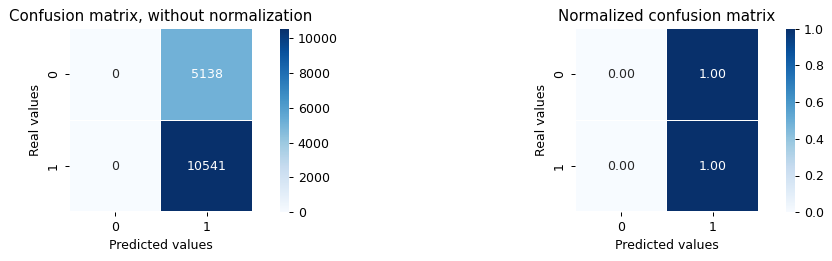

In [27]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_dummy)

### Logistic Regression

#### Setting the model

In [28]:
LR_model = Pipeline([
    ("clf", LogisticRegression())
])

#### Fitting the model

In [29]:
# Fitting the Logistic Regression model
LR_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('clf', LogisticRegression())])

#### Predictions

In [30]:
# Calculating the probs for each class:
y_pred_log_prob = LR_model.predict_proba(xtest_preprocessed)

Best Threshold=0.614352, F0.5-Score=0.791


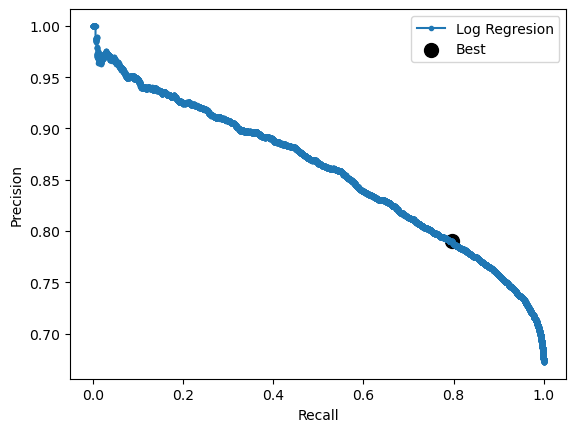

In [31]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_log_prob, 'Log Regresion')

In [32]:
# Set the proba threshold to get the predictions:
threshold = 0.61
y_pred_log = (y_pred_log_prob[:,1] >= threshold).astype('int')

#### Metrics

In [33]:
# Metrics display:
show_metrics(ytest, y_pred_log, y_pred_log_prob, 'Log Regresion')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_log))

Log Regresion metrics: 
Accuracy:  0.7205 
Precision:  0.7872 
Recall:  0.8007 
F0.5:  0.7899 
AUC:  0.7626408663806554

Classification Report

              precision    recall  f1-score   support

           0       0.58      0.56      0.57      5138
           1       0.79      0.80      0.79     10541

    accuracy                           0.72     15679
   macro avg       0.68      0.68      0.68     15679
weighted avg       0.72      0.72      0.72     15679



In [34]:
# Train metrics display:
y_pred_log_train = LR_model.predict(xtrain_preprocessed)
y_pred_log_prob_train = LR_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_log_train, y_pred_log_prob_train, 'Log Regresion')

Log Regresion metrics: 
Accuracy:  0.741 
Precision:  0.7557 
Recall:  0.9085 
F0.5:  0.782 
AUC:  0.7681556091045075


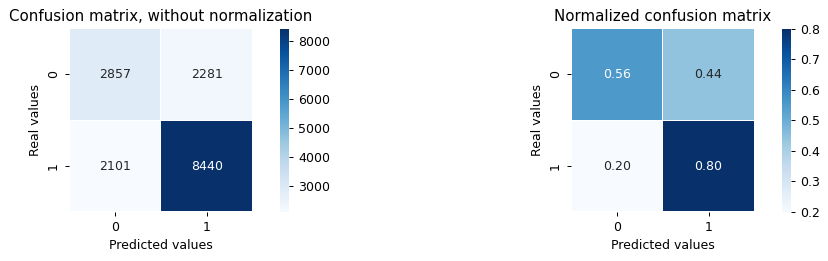

In [35]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_log)

### Naive Bayes

#### Setting the model

In [36]:
NB_model = Pipeline([
    ("clf",  MultinomialNB())
])

#### Fitting the model

In [37]:
# Fitting the Naive Bayes model
NB_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('clf', MultinomialNB())])

#### Predictions

In [38]:
# Calculating the probs for each class:
y_pred_nb_prob = NB_model.predict_proba(xtest_preprocessed)

Best Threshold=0.001490, F0.5-Score=0.761


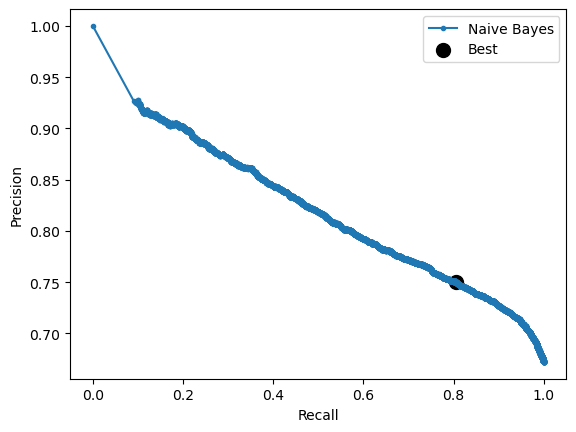

In [39]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_nb_prob, 'Naive Bayes')

In [40]:
# Set the proba threshold to get the predictions:
threshold = 0.001
y_pred_nb = (y_pred_nb_prob[:,1] >= threshold).astype('int')

#### Metrics

In [41]:
# Metrics display:
show_metrics(ytest, y_pred_nb, y_pred_nb_prob, 'Naive Bayes')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_nb))

Naive Bayes metrics: 
Accuracy:  0.695 
Precision:  0.7414 
Recall:  0.839 
F0.5:  0.7591 
AUC:  0.703043471951023

Classification Report

              precision    recall  f1-score   support

           0       0.55      0.40      0.46      5138
           1       0.74      0.84      0.79     10541

    accuracy                           0.70     15679
   macro avg       0.64      0.62      0.62     15679
weighted avg       0.68      0.70      0.68     15679



In [42]:
# Train metrics display:
y_pred_nb_train = NB_model.predict(xtrain_preprocessed)
y_pred_nb_prob_train = NB_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_nb_train, y_pred_nb_prob_train, 'Naive Bayes')

Naive Bayes metrics: 
Accuracy:  0.5666 
Precision:  0.8362 
Recall:  0.442 
F0.5:  0.7096 
AUC:  0.7092306168478333


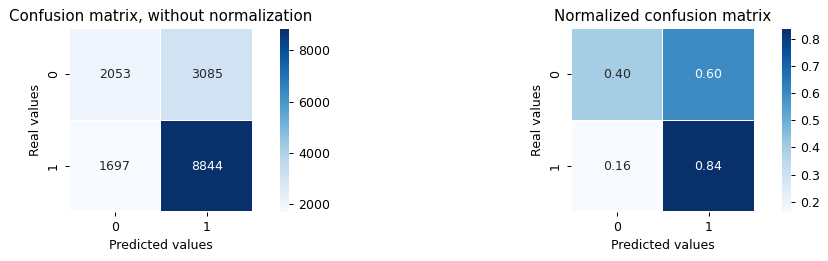

In [43]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_nb)

### Random Forest

#### Setting the model

In [44]:
RF_model = Pipeline([
    ("clf",  RandomForestClassifier(n_jobs=-1))
])

#### Fitting the model

In [45]:
# Fitting the Random Forest model
RF_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('clf', RandomForestClassifier(n_jobs=-1))])

#### Predictions

In [46]:
# Calculating the probs for each class:
y_pred_rf_prob = RF_model.predict_proba(xtest_preprocessed)

Best Threshold=0.573333, F0.5-Score=0.797


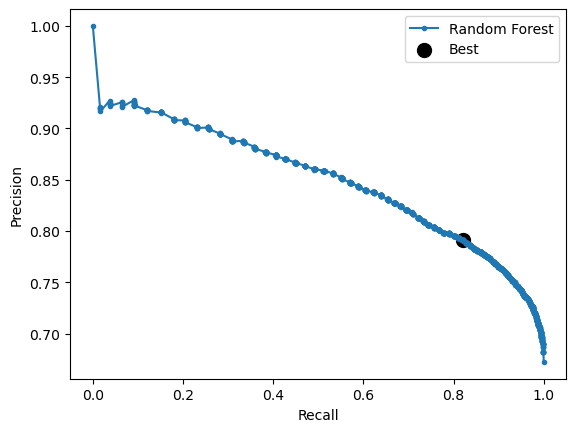

In [47]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_rf_prob, 'Random Forest')

In [48]:
# Set the proba threshold to get the predictions:
threshold = 0.57
y_pred_rf = (y_pred_rf_prob[:,1] >= threshold).astype('int')

#### Metrics

In [49]:
# Metrics display:
show_metrics(ytest, y_pred_rf, y_pred_rf_prob, 'Random Forest')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_rf))

Random Forest metrics: 
Accuracy:  0.7382 
Precision:  0.783 
Recall:  0.8446 
F0.5:  0.7946 
AUC:  0.7640703528814751

Classification Report

              precision    recall  f1-score   support

           0       0.62      0.52      0.57      5138
           1       0.78      0.84      0.81     10541

    accuracy                           0.74     15679
   macro avg       0.70      0.68      0.69     15679
weighted avg       0.73      0.74      0.73     15679



In [50]:
# Train metrics display:
y_pred_rf_train = RF_model.predict(xtrain_preprocessed)
y_pred_rf_prob_train = RF_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_rf_train, y_pred_rf_prob_train, 'Random Forest')

Random Forest metrics: 
Accuracy:  0.9913 
Precision:  0.9928 
Recall:  0.9943 
F0.5:  0.9931 
AUC:  0.9995846976681134


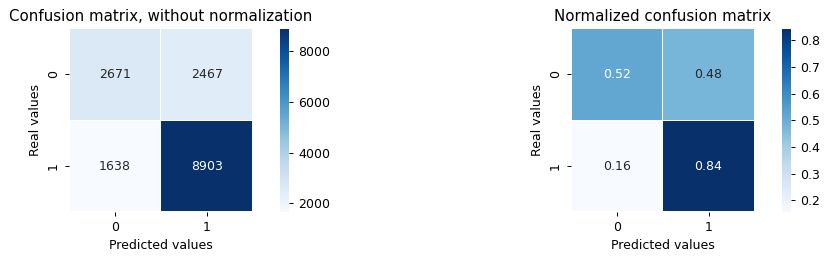

In [51]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_rf)

### XGBoost

#### Setting the model

In [52]:
XGB_model = Pipeline([
        ("clf", XGBClassifier())
])

#### Fitting the model

In [53]:
# Fitting the XGBoost model
XGB_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

#### Predictions

In [54]:
# Calculating the probs for each class:
y_pred_xgb_prob = XGB_model.predict_proba(xtest_preprocessed)

Best Threshold=0.666503, F0.5-Score=0.808


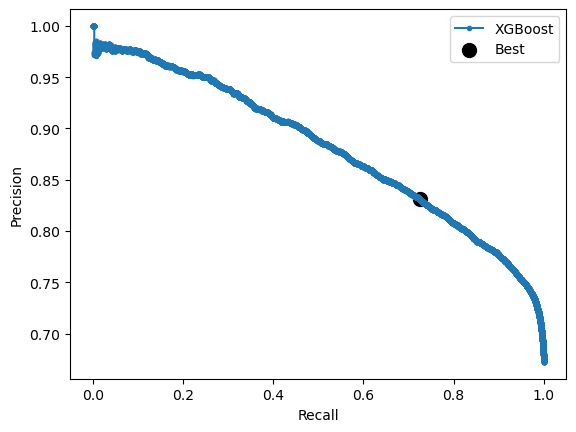

In [55]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_xgb_prob, 'XGBoost')

In [56]:
# Set the proba threshold to get the predictions:
threshold = 0.67
y_pred_xgb = (y_pred_xgb_prob[:,1] >= threshold).astype('int')

#### Metrics

In [57]:
# Metrics display:
show_metrics(ytest, y_pred_xgb, y_pred_xgb_prob, 'XGBoost')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_xgb))

XGBoost metrics: 
Accuracy:  0.7153 
Precision:  0.8328 
Recall:  0.7213 
F0.5:  0.8079 
AUC:  0.795158381539263

Classification Report

              precision    recall  f1-score   support

           0       0.55      0.70      0.62      5138
           1       0.83      0.72      0.77     10541

    accuracy                           0.72     15679
   macro avg       0.69      0.71      0.70     15679
weighted avg       0.74      0.72      0.72     15679



In [58]:
# Train metrics display:
y_pred_xgb_train = XGB_model.predict(xtrain_preprocessed)
y_pred_xgb_prob_train = XGB_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_xgb_train, y_pred_xgb_prob_train, 'XGBoost')

XGBoost metrics: 
Accuracy:  0.8019 
Precision:  0.804 
Recall:  0.9328 
F0.5:  0.8268 
AUC:  0.8718149500624971


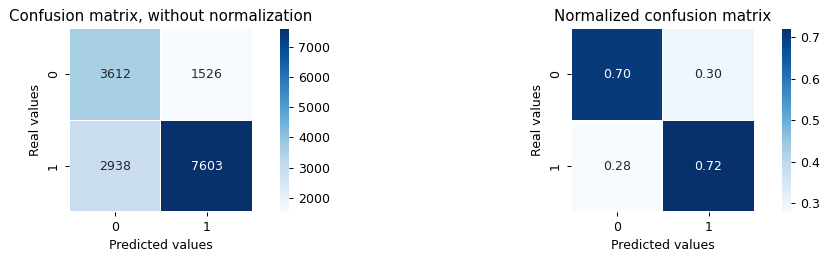

In [59]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_xgb)

### LGBM

#### Setting the model

In [60]:
LGBM_model= Pipeline([
    ("clf", LGBMClassifier ())
])

#### Fitting the model

In [61]:
# Fitting the LGBM model
LGBM_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('clf', LGBMClassifier())])

#### Predictions

In [62]:
# Calculating the probs for each class:
y_pred_lgbm_prob = LGBM_model.predict_proba(xtest_preprocessed)

Best Threshold=0.647037, F0.5-Score=0.807


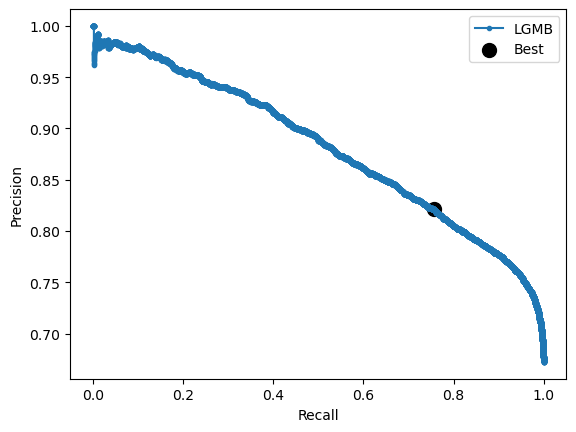

In [63]:
# Plotting Precision-recall relation to maximize F0.5 Score:
plot_precision_recall_curve(ytest, y_pred_lgbm_prob, 'LGMB')

In [64]:
# Set the proba threshold to get the predictions:
threshold = 0.65
y_pred_lgbm = (y_pred_lgbm_prob[:,1] >= threshold).astype('int')

#### Metrics

In [65]:
# Metrics display:
show_metrics(ytest, y_pred_lgbm, y_pred_lgbm_prob, 'LGBM')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_lgbm))

LGBM metrics: 
Accuracy:  0.7231 
Precision:  0.822 
Recall:  0.7507 
F0.5:  0.8067 
AUC:  0.7946215151506311

Classification Report

              precision    recall  f1-score   support

           0       0.57      0.67      0.61      5138
           1       0.82      0.75      0.78     10541

    accuracy                           0.72     15679
   macro avg       0.69      0.71      0.70     15679
weighted avg       0.74      0.72      0.73     15679



In [66]:
# Train metrics display:
y_pred_lgbm_train = LGBM_model.predict(xtrain_preprocessed)
y_pred_lgbm_prob_train = LGBM_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_lgbm_train, y_pred_lgbm_prob_train, 'LGBM')

LGBM metrics: 
Accuracy:  0.7754 
Precision:  0.7768 
Recall:  0.9343 
F0.5:  0.8039 
AUC:  0.8310253604785542


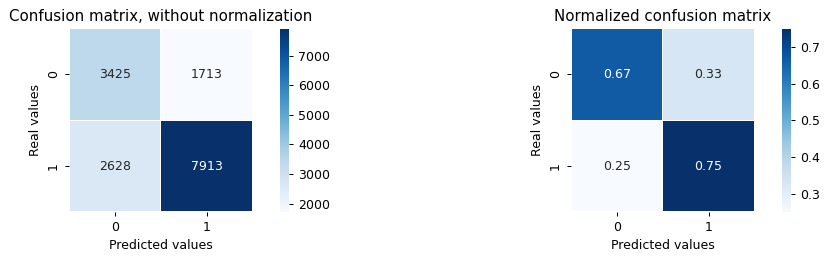

In [67]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_lgbm)

### SGD

#### Setting the model 

In [68]:
SGD_model= Pipeline([
    ("clf", SGDClassifier(loss = 'log_loss'))
])

#### Fitting the model

In [69]:
# Fitting the SGD model
SGD_model.fit(xtrain_preprocessed, ytrain)

Pipeline(steps=[('clf', SGDClassifier(loss='log_loss'))])

#### Predictions

In [70]:
# Calculating the probs for each class:
y_pred_sgd_prob = SGD_model.predict_proba(xtest_preprocessed)

Best Threshold=0.999037, F0.5-Score=0.765


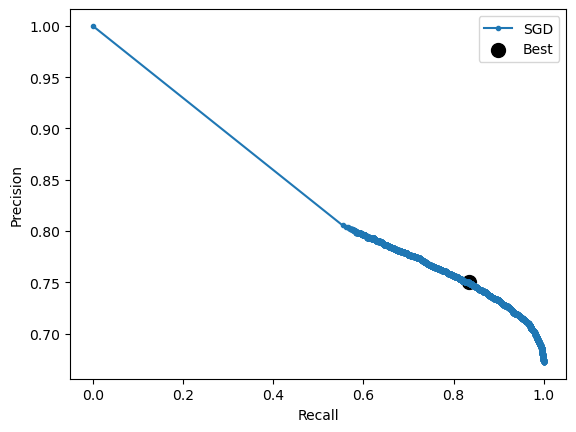

In [71]:
# Plotting Precision-recall relation to maximize F2 Score:
plot_precision_recall_curve(ytest, y_pred_sgd_prob, 'SGD')

In [103]:
# Set the proba threshold to get the predictions:
threshold = 0.99
y_pred_sgd = (y_pred_sgd_prob[:,1] >= threshold).astype('int')

#### Metrics

In [104]:
# Metrics dispaly:
show_metrics(ytest, y_pred_sgd, y_pred_sgd_prob, 'SGD')
print("\nClassification Report\n")
print(classification_report(ytest, y_pred_sgd))

SGD metrics: 
Accuracy:  0.7061 
Precision:  0.7421 
Recall:  0.8625 
F0.5:  0.7635 
AUC:  0.6886170052994056

Classification Report

              precision    recall  f1-score   support

           0       0.58      0.39      0.46      5138
           1       0.74      0.86      0.80     10541

    accuracy                           0.71     15679
   macro avg       0.66      0.62      0.63     15679
weighted avg       0.69      0.71      0.69     15679



In [105]:
# Train metrics display:
y_pred_sgd_train = SGD_model.predict(xtrain_preprocessed)
y_pred_sgd_prob_train = SGD_model.predict_proba(xtrain_preprocessed)
show_metrics(ytrain, y_pred_sgd_train, y_pred_sgd_prob_train, 'SGD')

SGD metrics: 
Accuracy:  0.7167 
Precision:  0.7312 
Recall:  0.9149 
F0.5:  0.7618 
AUC:  0.6971900933088945


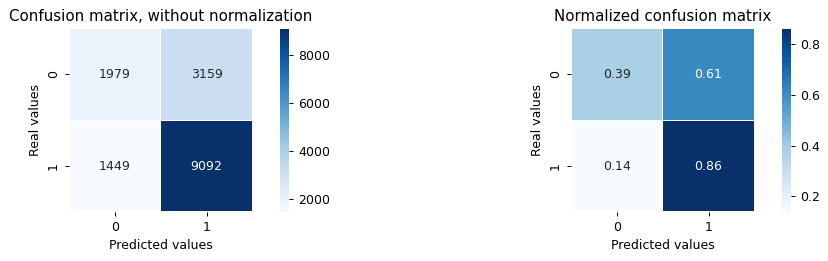

In [106]:
# Confusion matrix display:
confusion_matrix_plot(ytest, y_pred_sgd)

#### Pickle

We are going to save the models in a pickle format.

In [76]:
# models = [
#     base_model,
#     NB_model,
#     LR_model,
#     RF_model,
#     XGB_model,
#     LGBM_model,
#     SGD_model
# ]

# filenames = [
#     '../models/restaurants/base_model.pkl',
#     '../models/restaurants/LR_model.pkl',
#     '../models/restaurants/NB_model.pkl',
#     '../models/restaurants/RF_model.pkl',
#     '../models/restaurants/XGB_model.pkl',
#     '../models/restaurants/LGBM_model.pkl',
#     '../models/restaurants/SGD_model.pkl'
# ]

# save_models_to_parquet(models,filenames)

Loading the models from a pickle format.

In [77]:
# filenames = [
#     '../models/restaurants/base_model.pkl',
#     '../models/restaurants/LR_model.pkl',
#     '../models/restaurants/NB_model.pkl',
#     '../models/restaurants/RF_model.pkl',
#     '../models/restaurants/XGB_model.pkl',
#     '../models/restaurants/LGBM_model.pkl',
#     '../models/restaurants/SGD_model.pkl'
# ]

# base_model, LR_model, NB_model, RF_model, XGB_model, LGBM_model, SGD_model = load_models_from_parquet(filenames)

We have chosen XGBoost as the best model. The metric chosen when we were making the selection was precision = TP / (TP + FP). We have considered looking for a high Precision metric trying to minimize false positives as much as possible. In this line of business, the highest cost will be that of rating a restaurant as good (class 1) and then the user subsequently has a bad experience there. Therefore, we have considered that XGBOOST is the best model since it minimizes false positives the most among those with the highest precision, as can be seen in its confusion matrix. In addition, it has the least overfitting. Therefore, the model has a precision of 0.83 with a FP rate of 0.3.

### Tunning XGBoost

In [78]:
# Setting the model:
clf_xgboost_cv = XGBClassifier()

#### Fitting the model

In [79]:
params = {
 'max_depth' : [6, 8, 10],
 'min_child_weight' : [3, 5],
 'gamma': [0.0,0.2, 0.4],
 'colsample_bytree' : [0.5 , 0.7]
}

In [80]:
## Randomized Search CV
clf_xgboost_cv = GridSearchCV(clf_xgboost_cv, params,cv=5, n_jobs=-1)

In [81]:
# Fitting the model
clf_xgboost_cv.fit(xtrain_preprocessed, ytrain)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'gamma': [0.0, 0.2, 0.4], 'max_depth': [6, 8, 10],
                         'min_child_weight': [3, 5]})

#### Predict

In [82]:
# Calculating the probs for each class:
y_pred_xgboost_prob = clf_xgboost_cv.predict_proba(xtest_preprocessed)

Best Threshold=0.647336, F0.5-Score=0.809


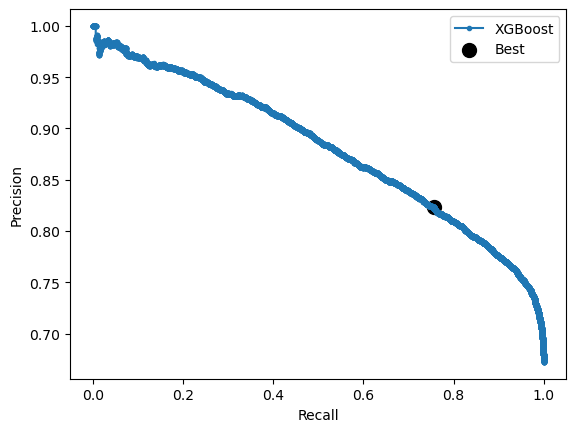

In [83]:
# Plotting Precision-recall relation to maximize F2 Score:
plot_precision_recall_curve(ytest, y_pred_xgboost_prob, 'XGBoost')

In [84]:
# Set the proba threshold to get the predictions:
threshold = 0.65
y_pred_xgboost = (y_pred_xgboost_prob[:,1] >= threshold).astype('int')

#### Metrics

In [85]:
# Metrics display:
show_metrics(ytest, y_pred_xgboost, y_pred_xgboost_prob, 'XGBOOST')
print("Classification Report")
print(classification_report(ytest, y_pred_xgboost))

XGBOOST metrics: 
Accuracy:  0.7252 
Precision:  0.8236 
Recall:  0.7524 
F0.5:  0.8083 
AUC:  0.7957983043393664
Classification Report
              precision    recall  f1-score   support

           0       0.57      0.67      0.61      5138
           1       0.82      0.75      0.79     10541

    accuracy                           0.73     15679
   macro avg       0.70      0.71      0.70     15679
weighted avg       0.74      0.73      0.73     15679



In [86]:
# Train metrics display
y_pred_xgboost_prob_train = clf_xgboost_cv.predict_proba(xtrain_preprocessed)
y_pred_xgboost_train = (y_pred_xgboost_prob_train[:,1] >= threshold).astype('int')
show_metrics(ytrain, y_pred_xgboost_train, y_pred_xgboost_prob_train, 'XGBOOST')

XGBOOST metrics: 
Accuracy:  0.7743 
Precision:  0.8651 
Recall:  0.7871 
F0.5:  0.8483 
AUC:  0.8571809741210511


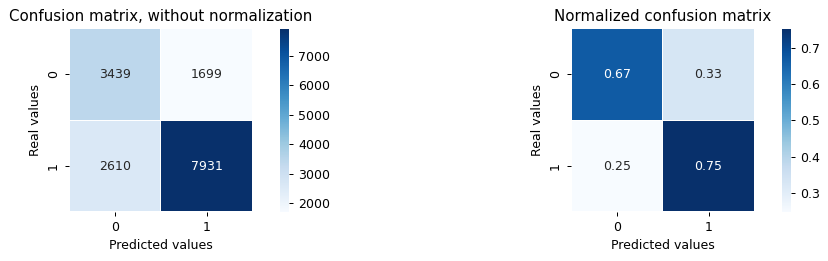

In [87]:
# confusion matrix display:
confusion_matrix_plot(ytest, y_pred_xgboost)

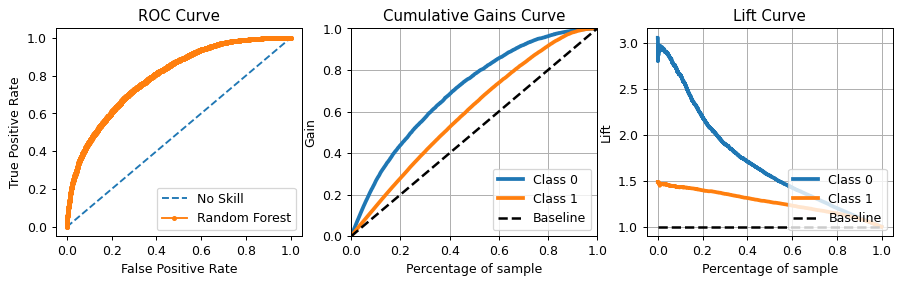

In [88]:
curves(ytest, y_pred_xgboost_prob)

####  Roc Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve represents two parameters:True positive rate and False positive rate.

True positive rate (TPR) is synonymous with completeness and is therefore defined as follows: TP/(TP+FN)

False Positive Rate (FPR) is defined as follows: FP/(TN+FP) 

An ROC curve represents TPR (sensibilitiy) versus FPR (1-specificity) at different classification thresholds. Therefore, if for a particular threshold of the ROC curve the probability of classifying a value as a positive class is above the ROC curve, we will classify it as a positive class. If it is below, we will classify it as a negative class.
 As the classification threshold decreases, more items are classified as positive, which increases both false positives and true positives. 
 
AUC stands for "area under the ROC curve". That is, the AUC measures the full two-dimensional area under the full ROC curve (think of an integral calculation) from (0.0) to (1.1). This score gives us a good idea of how well the model works.In this case, AUC score is 0.85, it means that there is a 85% probability that the model can distinguish between positive and negative class.

#### Cumulative Gain Curve

The cumulative gains plot shows the percentage of the total number of cases in a given category "win" by targeting a percentage of the total number of cases.The curve is constructed by ordering all model predictions by their probability of belonging to the positive class, and then calculating the fraction of positive cases at each probability cutoff point. For example, if we take the point on the curve for the "1" category (20%, 30%),you would expect the top 20% to contain approximately the 30% of all cases that actually take the "1" category. Likewise, the top 60% would contain approximately 75% of them. If you select the top 80% , you will get more than the 90% "1" category values of the data set.

The diagonal line is the "baseline" curve, if you select 10% of the cases from the randomly scored data set, you would expect to "win" approximately 10% of all cases that actually take the "1" category. As we move along the X-axis of the gain curve, its slope becomes less steep because we are adding data to the sample about which we are less certain.


#### Lift Curve

The lift graph is derived from the cumulative gain graph;  the Y-axis of the Lift Curve represents the gain of our model with respect to a random model.Thus, the 10% uplift for category "1" is 15% /10% = 1.5.

Knowing this we can learn more about our model and observe that it has an easy time predicting correctly the positive class ("1") for the values it has more "clear", but later suffers a drop and ends up looking like a random model.Therefore,it provides another way to view the information in the cumulative gain graph.

#### Pickle

We are going to save the final model in a pickle format.

In [107]:
# models = [
#     clf_xgboost_cv
# ]

# filenames = [
#     '../models/restaurants/final_model.pkl'
# ]

# save_models_to_parquet(models,filenames)

## Explicability

### Global Agnostic Methods

First of all, the global importance of the model variables from the xgboost will be shown and compared with the global importance obtained from the Permutation Importance values and with the shap values.

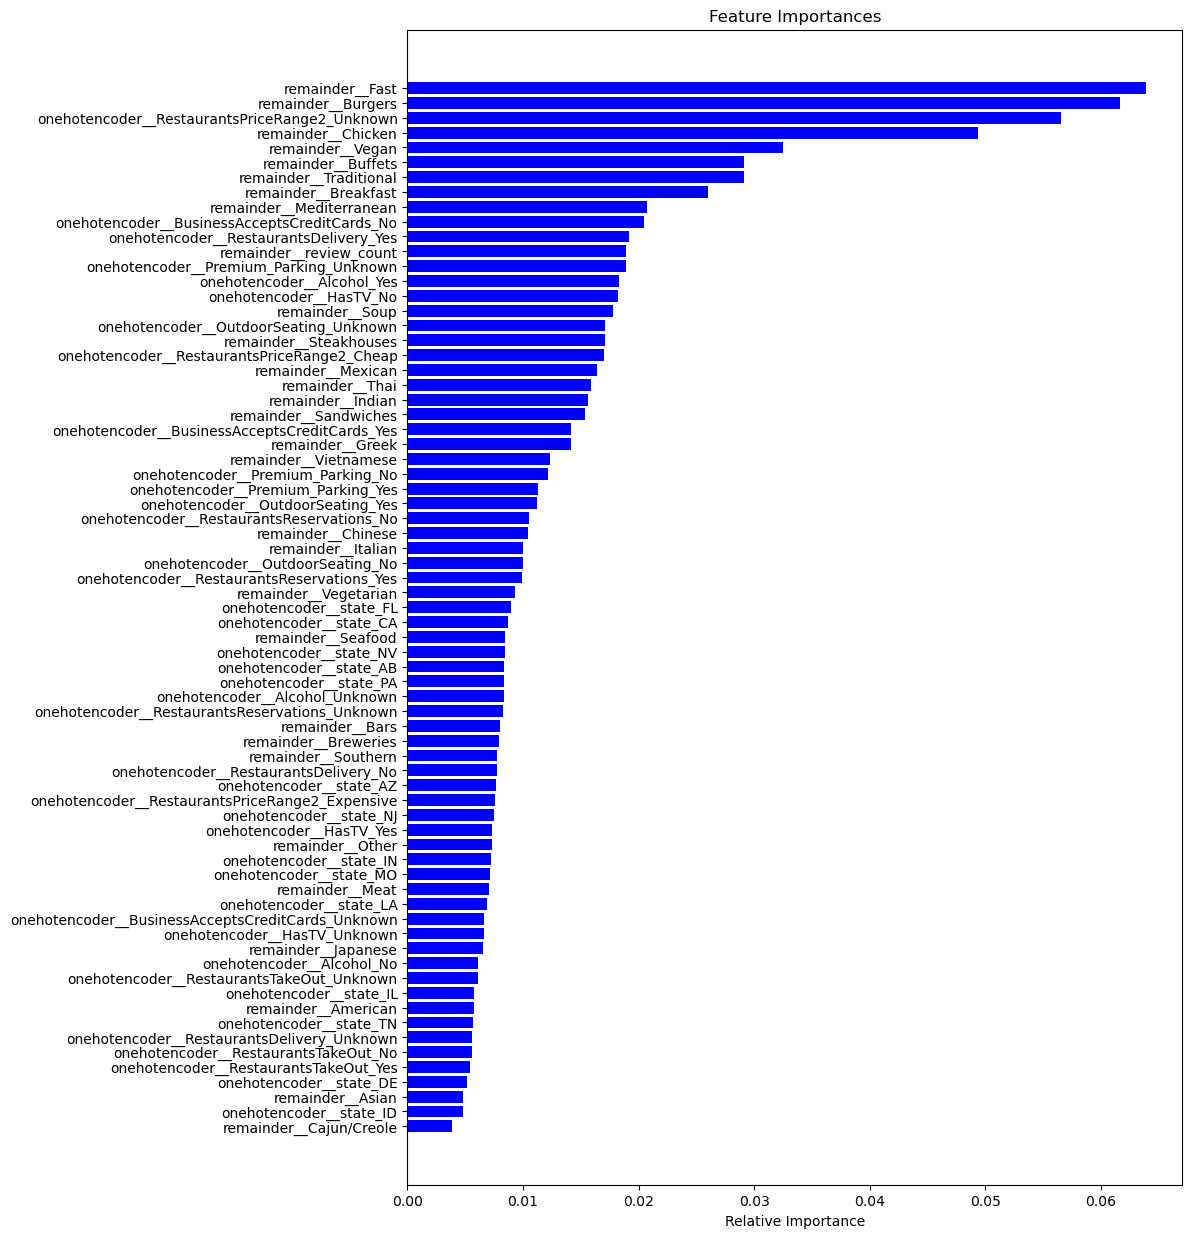

In [90]:
importances =clf_xgboost_cv.best_estimator_.feature_importances_
#showing the most importance variables from the model
indices = np.argsort(importances)
features = xtest_preprocessed.columns
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), (features[i] for i in indices))
plt.xlabel('Relative Importance')
plt.show()

#### Permutation Importance

Permutation Importance is a technique used to measure the importance of each feature (or column) in a dataset when training a machine learning model. It is based on the idea of permuting the values of each feature and then measuring how this affects the accuracy of the model.

For example, if you have a dataset with three features (A, B, and C) and a decision tree model that is being trained to predict whether or not a person will get diabetes, Permutation Importance will be a good way to determine which of the three features is most important for prediction.

In [91]:
permutation= PermutationImportance(clf_xgboost_cv, random_state=1).fit(xtest_preprocessed, ytest)
eli5.show_weights(permutation, feature_names = xtest_preprocessed.columns.tolist())

We can see that our model when classifies a restaurant as good or bad is generally based on the type of food it usually offers together with the number of reviews it has. Something that was to be expected at first.

### Partial Dependence Plots

We have selected the following four variables since all of them ( with the exception of `onehotencoder__RestaurantsPriceRange2_Expensive`), are the most important variables in the model according to the Feature Importance and Permutation Importance analyzed above.

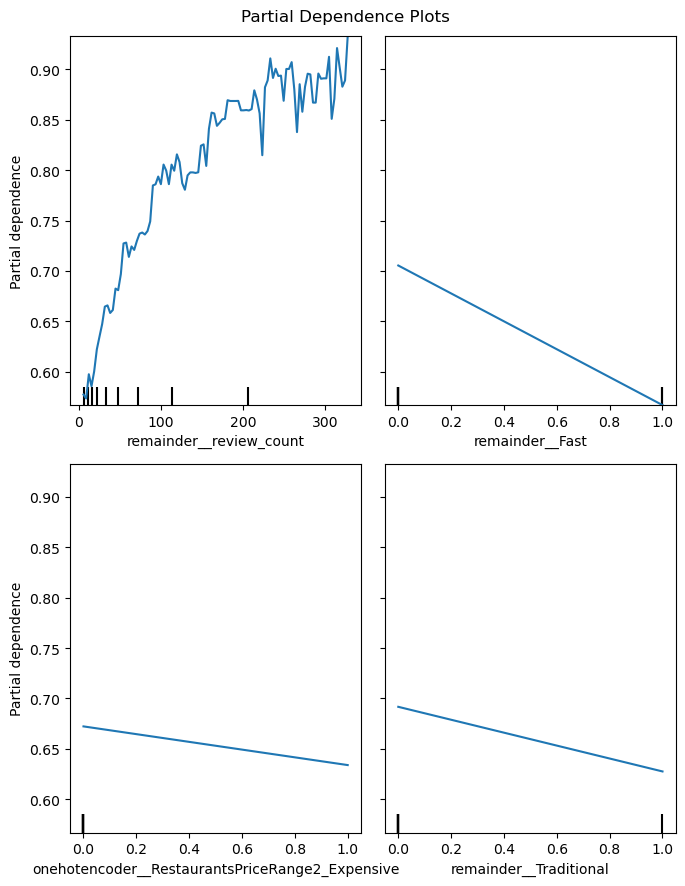

In [92]:
features = ['remainder__review_count','remainder__Fast','onehotencoder__RestaurantsPriceRange2_Expensive','remainder__Traditional']
n_cols = 2
n_rows = 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(7, 9))
PartialDependenceDisplay.from_estimator(clf_xgboost_cv,xtrain_preprocessed, xtrain_preprocessed[features], ax=ax, n_cols=n_cols)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout();

We can see how the `remainder__review_count` and `remainder__Fast` variables do partially influence the target. As the number of reviews increases or the probability that the restaurant is a fast food restaurant decreases, the probability that the restaurant is classified as good (class 1) increases. However, we can observe that the other two variables do not have so high partial dependence on the target as they have a lower slope in their respective graphs against the target.

###  SHAP

Global explainability with SHAP values refers to the use of a method called SHAP (SHapley Additive exPlanation) to understand and explain the overall behavior of a machine learning model. SHAP values are a technique for explaining the contribution of each feature, or input variable, to the prediction of a machine learning model. They can be used to explain the overall behavior of a model by understanding how each feature impacts the model's output, as well as to compare the influence of different features on the model's prediction.

In [93]:
# load JS visualization code to notebook
shap.initjs()

In [94]:
clf_xgboost_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [95]:
explainer = shap.TreeExplainer(clf_xgboost_cv.best_estimator_)

As mentioned above, let's check if with the shap values we find variables with similar overall importance in the model.

In [96]:
shap_values = explainer.shap_values(xtest_preprocessed)

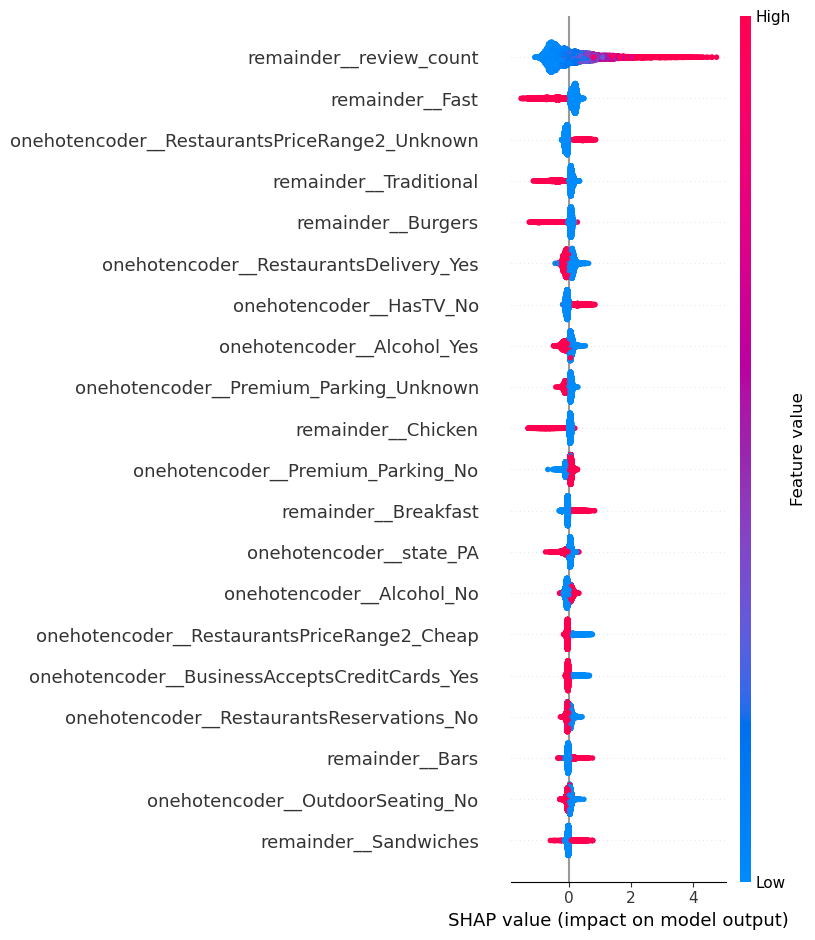

In [97]:
shap.summary_plot(shap_values, xtest_preprocessed)

As we can see, the overall importance of each variable in the model is very similar to that obtained in the previous methods. The higher the number of reviews, the more positive impact it will have on the model when classifying restaurants as good (class 1). In the case of the fast variable we see that the fact of having a higher  probability of being   a fast food restaurant will have a greater negative impact on the model classifying the restaurants as bad (class=0).

### Local Agnostic Methods

One of the main advantages of SHAP is that it provides a "local" explanation, i.e., it allows us to understand how each feature individually affects the prediction of a model for a specific observation.

The local explainability of SHAP is based on the concept of Shapley value. The Shapley value measures the contribution of each feature to a given prediction, taking into account the interaction between all features. This means that the Shapley value of a given feature for a specific observation depends not only on the feature itself, but also on how it is combined with the other features.


In [98]:
shap.force_plot(explainer.expected_value, shap_values[0], xtest_preprocessed.iloc[0,:], link='logit')

Let's try to explain why this first observation of the test is likely to classify the restaurant as good (class 1).The variables with their values in the red band (tend to increase the probability of the output) have more weight than the variables in the blue band (tend to decrease the probability of the output), classifying this restaurant as a good one. As we said before, they have a high number of reviews which was a variable that influenced the model very positively. In addition, they offer seafood, typical of higher level restaurants.


In [99]:
shap.force_plot(explainer.expected_value, shap_values[200], xtest_preprocessed.iloc[200,:], link='logit')

Here is another example that clearly shows why this restaurant has a high probability of being good (0.74). It has a high number of reviews and also the reminder fast variable, one of the most influential in this observation, is zero. We saw earlier that the variable fast (fast food) had a very negative influence on the model, classifying restaurants with lower ratings (class 0).

In [100]:
shap.force_plot(explainer.expected_value, shap_values[27], xtest_preprocessed.iloc[27,:], link='logit')

Finally here we can see that being a fast food and a burger restaurant and having a lower number of reviews, the restaurant has a very high probability of being classified as a lower level restaurant by the model. In addition, this local analysis coincides with the global analysis performed previously, since they were the most important variables of the model.

Analyzing different observations, we have realized that in general, locally, restaurants in the "Breakfast" category are very well rated. This fact is consistent with the global explicability analyzed above.